In [1]:
import os
import sys
# add parent directory to path to be able to load local RLC lib.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from RLC.move_chess.environment import Board
from RLC.move_chess.agent import Piece
from RLC.move_chess.learn import Reinforce

In [4]:
env = Board()
env.render()
env.visual_board

[['[S]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[F]', '[ ]', '[ ]']]

# model free methods

Previously the shown methods were used to predict the environment state based on the previous state and the transition probabilities to those states. However, in some cases the environment is an unknown as well, making these methods not useful e.g. flying a drone (control). For these cases we use model-free methods i.e. techniques that don't leverage any prior knowledge about the environment's dynamics. We can use them to either predict or control. In prediction we try to estimate the value function of an unknown MDP, while in control methods we try to optimize the value function of an unknown MDP. Control based methods are used for problems where the MDP is unknown but the experience can be sampled or problems with known MDP where the model is too big to use and needs to be sampled.

Prediction:
- Monte Carlo policy evaluation
- Temporal Difference (TD) Learning
- TD-Lambda


Control:
- on-policy / off-policy Monte carlo (action-value)
- State–action–reward–state–action (Sarsa)
- Q learning

# Prediction

We predict the value function by sampling (policy evaluation).

## Online vs Offline learning

Here online learning means that the result is updated after each instance that comes in (i.e. sliding window). Offline means that the result is only updated when all data to calculate the next result are in.

## on-policy vs off-policy learning

On-policy learning is learning about policy $\pi$ from experience by sampling from $\pi$.
Off-policy learning is learning about policy $\pi$ from experience by sampling from $\mu$.This is important because in this case we can learn form old policies. We can learn the optimal policy while following an exploratory policy and learn about multiple policies while following one policy. The policy used to generate the behavior is called the behavior policy, while the policy that is being improved is called the estimation policy.

## Monte Carlo (MC) policy evaluation

Monte-Carlo method samples actions until the end of an episode to approximate total rewards. Most reinforcement learning problems can be broken down into sequences in which an agent interacts with its environment until it reaches a certain terminal state that initiates a reset to its initial state. This is an episode.

In MC RL the goal is to learn the value function v under policy $\pi$ from episodes building experience. 
The expected return is replaced by the emperical mean return. (return is the total discounted reward $G_{t} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T - 1} R_{T}$). We can use first / every visit MC, this means we update the average return the first / every time the state s is visited in an episode.

- initialize
- repeat
    - Generate an episode using $\pi$
    - for each s in episode:
        G = Return following the first / every occurence of s
        $$N(s) = N(s) + 1$$
        $$S(s) = S(s) + G$$
        $$v(s) = S(s) / N(s)$$

By the law of large numbers policy evaluation will converge. 

Also MC can be updated in an incremental fashion:
   - Each state $s_{t}$ is updated with return $G_{t}$ and $N_{t}$ is incremented.
   - Now the value function can be rewritten as:
$$ v(s_{t}) = v(s_{t}) + \frac{1}{N_{t}(s)} (G_{t} - v(s_{t}))$$
   - In non-stationary problems a running mean can be used (do not keep previous results) where $\alpha$ is the learning rate.
$$ v(s_{t}) = v(s_{t}) + \alpha (G_{t} - v(s_{t}))$$ 

MC has high variance and zero bias. 
This means 
   - good convergence properties
   - not very sensitive to initial value
   - Very simple to understand and use

Adiitionally MC is usually more efficient in non-Markov environments

## Temporal Difference (TD) learning

TD methods learn directly from incomplete episodes by using bootstrapping (dynamic programming also uses bootstrapping (solution previous section)). This means TD updates a guess towards a guess. It also means that an episode does not need to end to be able to learn as was the case with MC. 

### TD(0)
The expression can be rewritten (for TD(0)) as
$$ v(s_{t}) = v(s_{t}) + \alpha \ \delta_{t}$$
with TD error $\delta_{t} = R_{t+1} + \gamma v(s_{t+1}) - v_{t}$ which uses an estimated return instead of the actual return $G_{t}$.

TD has low variance and some bias. The low variance due to dependency on one random action / transition / reward instead of multiple in MC. This in turn also causes the bias.
This means
   - Usually more efficient than MC
   - TD(0) converges to v(s) (but not always with function approximation)
   - More sensitive to initial value

Additionally, TD is usually more efficient in Markov environments.

### n-step TD

Instead of using $G_{t}^{(0)} =  R_{t+1} + \gamma v(s_{t+1})$, we use the n-step return $G_{t}^{(n)} =  R_{t+1} + \gamma R_{t+2} + \ldots + \gamma^{n-1} R_{t+n} + \gamma^{n} v(s_{t+n})$. One can show formally that on-line and off-line TD prediction methods using n-step backups converge to the correct predictions under appropriate technical conditions. The n-step TD methods thus form a family of valid methods, with one-step TD methods and Monte Carlo methods as extreme members.
Nevertheless, -step TD methods are rarely used because they are inconvenient to implement. Computing n-step returns requires waiting n-steps to observe the resultant rewards and states. For large n, this can become problematic, particularly in control applications. The significance of n-step TD methods is primarily for theory and for understanding related methods that are more conveniently implemented.

### TD($\lambda$)

The $\lambda$-return combines all n-step returns using a weighting.
$$G_{t}^{\lambda} =  (1 - \lambda) \sum_{n = 1}^{\infty} \lambda^{n-1} G_{t}^{(n)}$$
<div>
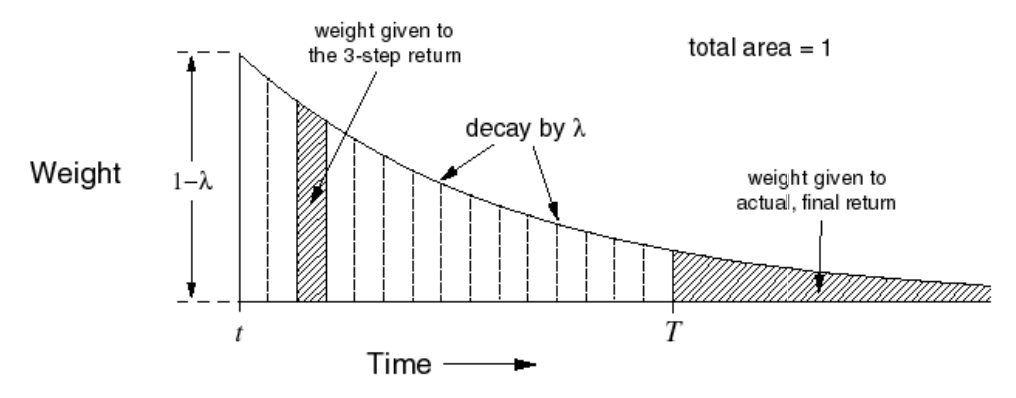
</div>

Forward view TD looks into the future to calculate $G_{t}^{\lambda}$. This can only be done for complete episodes, like MC. The specific way this shift is done is interesting, but not obviously better or worse than the way it is done with simple n-step methods by varying n. Ultimately, the most compelling motivation for the $\lambda $ way of mixing n-step backups is that there is a simple algorithm TD($\lambda $) for achieving it. 

The mechanistic, or backward, view of TD($\lambda $) is useful because it is simple conceptually and computationally. In particular, the forward view itself is not directly implementable because it is acausal, using at each step knowledge of what will happen many steps later. The backward view provides a causal, incremental mechanism for approximating the forward view and, in the off-line case, for achieving it exactly.

In the backward view of TD($\lambda $), there is an additional memory variable associated with each state, its eligibility trace. This trace combines  two heuristics. 
   - Frequency heuristic: assign credit to most frequent states
   - Recency heuristic: assign credit to most recent states.
The eligibility trace is given by
$$E_{0}(s)$$
$$E_{t}(s) = \gamma \ \lambda E_{t-1}(s) + 1 \ if \ state \ is \ visited $$
$$E_{t}(s) = \gamma \ \lambda E_{t-1}(s) \ if \ state \ is \ not \ visited $$ 

In the backward view of TD($\lambda $), the global TD error signal triggers proportional updates to all recently visited states, as signaled by their nonzero traces:
$$ \Delta v = \alpha \delta_{t} E_{t}(s) $$

The forward view only matches approximately with the backward view in case of online updates. For offline updates the equivalence is exact. Extra: True online TD($\lambda$) was developed which has exact equivalence with offline updates.

Online TD($\lambda$) algorithm:
- initialize V(s), E(s)
- repeat episode
   - initalize s
   - repeat step
      - take action a under policy $\pi$
      - $\delta = R_{ss'}^{a} + \gamma v(s') - v(s)$
      - E(s) = E(s) + 1
      - for all s
         - $ v(s) = v(s) + \alpha \ \delta \ E(s) $
         - $E(s) = \gamma \lambda E(s)$
      - s = s'
   - until episode complete ( s is terminal)

We can also apply an off-policy variant with importance sampling. Here we taken actions under a policy $\pi$' and the expression of $\delta$ changes to
$$\delta = \frac{\pi(a)}{\pi ' (a)}  (R_{ss'}^{a} + \gamma v(s')) - v(s)$$

This has a much lower variance than importance sampling on MC and for it to work well the policies only need to be similar over a single step.

### TD(1)
TD(1) is a way of implementing Monte Carlo algorithms that is more general than those presented earlier and that significantly increases their range of applicability. Whereas the earlier Monte Carlo methods were limited to episodic tasks, TD(1) can be applied to discounted continuing tasks as well when applied online. However as was the case with TD($\lambda$) the equivalence with MC is only exact when using true online TD(0).

<div>
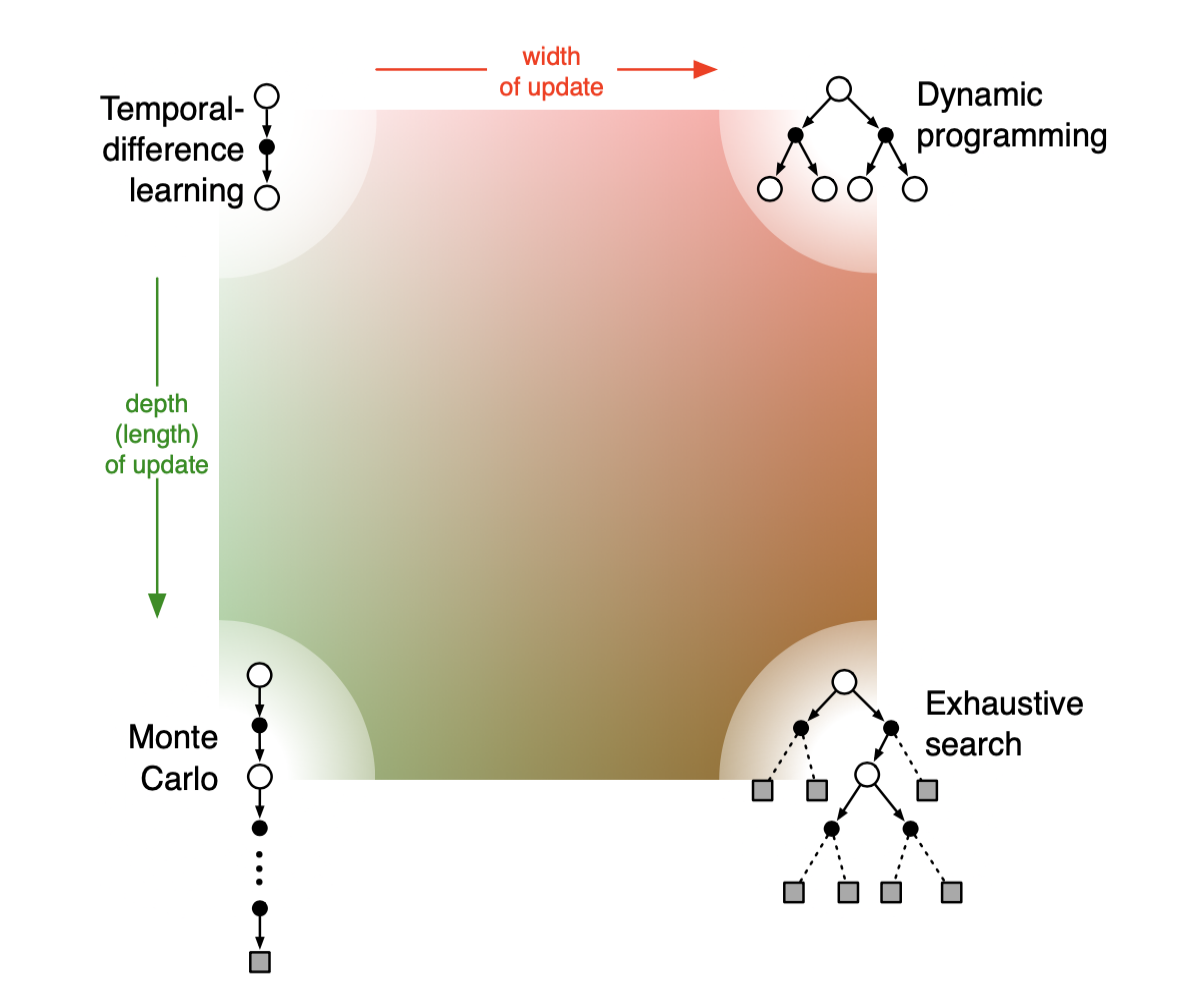

In [5]:
# MC first visit
#reset
p = Piece(piece='king')
r = Reinforce(p,env)
    
eps = 0.5
gamma = 1
k_max=100

for k in range(k_max):
    r.agent.value_function_prev = r.agent.value_function.copy()
    r.monte_carlo_evaluation(eps, gamma, True)

r.improve_policy()        
# r.visualize_policy()

In [6]:
# MC multiple visits
#reset
p = Piece(piece='king')
r = Reinforce(p,env)
    
eps = 0.5
gamma = 1
k_max=100

for k in range(k_max):
    r.agent.value_function_prev = r.agent.value_function.copy()
    r.monte_carlo_evaluation(eps, gamma, False)
r.improve_policy()
# r.visualize_policy()

# converge at almost the same number of iterations, 
# but it seems that multiple visits performs stabler between iterations.
# Can also be updated in a greedy manner i.e. after each iteration.
# As can be noticed, not all states are correct at the border. This is the exploring starts problem
# we do not have enough occurences to provide a good behavior there.

In [7]:
# TD
# TD(0)
#reset
p = Piece(piece='king')
r = Reinforce(p,env)
    
eps = 0.5
gamma = 1
alpha=0.05
k_max=100

for k in range(k_max):
    r.TD_zero(eps, gamma, alpha)
    r.improve_policy()
# r.visualize_policy()

In [8]:
# TD(lambda)
#reset
p = Piece(piece='king')
r = Reinforce(p,env)
    
eps = 0.5
gamma = 1
lamb = 0.7
alpha=0.05
k_max=100

for k in range(k_max):
    r.TD_lambda(eps, gamma, alpha, lamb)
    r.improve_policy()
# r.visualize_policy()

# Control

We apply policy improvement directly on the action-value function $Q(s,a)$ to circumvent the necessity of the value function. We need to sample the action-value function for this. The same policy evaluation methods can be used as in the prediction case, only instead of sampling states we sample over state-action pairs. The only complication is that many relevant state-action pairs may never be visited. If $\pi$ is a deterministic policy, then in following $\pi$ one will observe returns only for one of the actions from each state. With no returns to average, the estimates of the other actions will not improve with experience. This is a serious problem because the purpose of learning action values is to help in choosing among the actions available in each state. To compare alternatives we need to estimate the value of all the actions from each state, not just the one we currently favor. This translates to the necessity of exploring starts. This means that every state-action pair has a non-zero probability of being the starting pair.

By using $\epsilon$-soft policies we force the agent to continually explore that means we can drop the exploring starts requirement. An $\epsilon$-soft policy assigns nonzero probability to each action in every state because of this $\epsilon$-soft agents continue to visit all state action pairs indefinitely. $\epsilon$-soft policies are always stochastic. Examples are $\epsilon$-greedy policies and the uniform random policy.

## Greedy in the Limit with Infinite Exploration

For policy evaluation to work for action values, we said that continual exploration must be assured. This would mean that every state and action are sampled infinitely often. This is easy to ensure in off-policy methods, by using any persistent exploration method (e.g., $\epsilon$-greedy). In on-policy schemes, if we want to converge to the optimal
policy, we must ensure that exploration eventually becomes small.

A learning policy is called Greedy in the Limit with Infinite Exploration(GLIE) if it satisfies the following two properties:
1. If a state is visited infinitely often, then each action in that state is chosen infinitely often (with probability 1).
2. In the limit (as t → ∞), the learning policy is greedy with respect to the learned Q-function (with probability 1).

## $\epsilon$-Greedy policy improvement

Persistent exploration method. All m actions are tried with a non-zero probability. The greedy action is chosen with probability 1- $\epsilon$ and a random action is chosen with probability $\epsilon$.

$$\pi (a | s) = \frac{\epsilon}{m} + 1 - \epsilon \ if \ a* = arg \max_{a} Q(s,a) $$ 
$$ \frac{\epsilon}{m}  \ otherwise$$

Can be GLIE if $\epsilon_{t} = \frac{c}{n_{t}(s)}$ with c between 0 and 1 and $n_{t}(s)$ the number of previous visits to state s. For monte carlo n = nr of episodes at that time. This is a form of UCB action selection, since $\epsilon$ will decline over time.

## Upper Confidence Bound (UCB) action selection

It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates. UCB focusses on actions whose estimates have a large degree of uncertainty. Here an upper bound estimate is made based on the true action values and the action is selected with the largest estimated upper bound.
$$a* = arg \max_{a} [ Q(s,a) + c \sqrt{\frac{ln \ t}{N_{t}(a)}}] $$

with $N_{t}(a)$ the number of times that action a has been selected prior to time t and c between 0 and 1 (exploration rate). The square-root term is a measure of the uncertainty or variance in the estimate of a’s value.

## Monte Carlo control

For on policy MC control, we do policy iteration using MC policy evaluation and for the policy improvement, we use $\epsilon$-Greedy policy improvement.

Off-policy Monte Carlo control methods follow the behavior policy while learning about and improving the estimation policy. This technique requires that the behavior policy have a nonzero probability of selecting all actions that might be selected by the estimation policy. To explore all possibilities, we require that the behavior policy be soft. Additionally, importance sampling is used to reduce the variance of the estimator.
- Q(s,a) arbitrary, C(s,a) = 0, (cumulative sum) $\pi$ an arbitrary deterministic policy
- repeat forever
   - select $\pi$' and use it to generate an episode
   - G = 0, W = 1
   - for each step of episode loop backwards (t=T-1, T-2 ... 0 )
       - $G = \gamma G + R_{t+1}$
       - $C(s,a)= C(s,a) + W$
       - $Q(s,a) = Q(s,a) + \frac{W}{C(s,a)} (G - Q(s,a))$
       - $\pi(s) = arg \max_{a} Q(s,a)$
       - quit episode when $a \ne \pi(s)$ (policies do not match)
       - $W = W \frac{1}{\pi ' (a \ | \ s)}$ (prob. choosing action)

A potential problem is that this method learns only from the tails of episodes, after the last nongreedy action. If nongreedy actions are frequent, then learning will be slow, particularly for states appearing in the early portions of long episodes. Potentially, this could greatly slow learning.
   
## State–action–reward–state–action (Sarsa)

On policy method using TD in the control loop. The name comes from the process in which the action gets updated. The procedure is as follows
- initialize Q(s,a)
- repeat episode
   - initalize s
   - choose a from s using policy derived from Q (e.g. $\epsilon$-greedy)
   - repeat step
      - take action a, observe $R_{ss'}^{a}$, s'
      - choose a' from s' using policy derived from Q (e.g. $\epsilon$-greedy)
      - $\delta = R_{ss'}^{a} + \gamma Q(s', a') - Q(s, a)$
      - $Q(s,a) = Q(s,a) + \alpha \delta $
      - s = s', a = a'
   - until episode complete ( s is terminal)

This approach is chosen over Monte Carlo when termination is not guaranteed for all policies. If a policy was ever found that caused the agent to stay in the same state, then the next episode would never end in MC. Step-by-step learning methods such as Sarsa do not have this problem because they quickly learn during the episode that such policies are poor, and switch to something else.

As with TD also a n-step and $\lambda$ variant exists. For the $\lambda$-variant the procedure is as follows
- initialize Q(s,a)
- repeat episode
   - initialize E(s,a) = 0
   - initalize s, a
   - repeat step
      - take action a, observe $R_{ss'}^{a}$, s'
      - choose a' from s' using policy derived from Q (e.g. $\epsilon$-greedy)
      - $\delta = R_{ss'}^{a} + \gamma Q(s', a') - Q(s, a)$
      - E(s, a) = E(s, a) + 1
      - for all s, a
         - $ Q(s, a) = Q(s, a) + \alpha \ \delta \ E(s, a) $
         - $ E(s, a) = \gamma \lambda E(s, a) $
      - s = s', a = a'
   - until episode complete ( s is terminal)
   
## Q-learning
 
In its simplest form one-step Q-learning the learned action-value function Q directly approximates the optimal one independent of the policy being followed by following this approach

- initialize Q(s,a)
- repeat episode
   - initalize s
   - choose a from s using policy derived from Q (e.g. $\epsilon$-greedy)
   - repeat step
      - take action a, observe $R_{ss'}^{a}$, s'
      - $Q(s,a) = Q(s,a) + \alpha [ R_{ss'}^{a} + \gamma \max_{a'} Q(s', a') - Q(s,a) $
      - s = s', a = a'
   - until episode complete ( s is terminal)

All that is required for correct convergence is that all pairs continue to be updated. The target policy is greedy w.r.t. Q(s,a) (see max operation). This can lead to significantly overestimating the action-values, leading to unstable training and low quality policy. The solution involves using two separate Q-value estimators, each of which is used to update the other. Using these independent estimators, we can create unbiased Q-value estimates of the selected actions using the opposite estimator. We can thus avoid maximization bias by disentangling our updates from biased estimates. This is called double Q learning.

In [9]:
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

eps = 0.5
for k in range(100):
    r.monte_carlo_learning(epsilon=eps)
    r.agent.policy = r.agent.action_function.copy()
r.visualize_policy()
mc_policy=r.agent.policy

[['→', '↘', '→', '↘', '↙', '←', '↑', '↙'],
 ['←', '↘', '↗', '↓', '↘', '→', '↓', '↙'],
 ['↗', '↘', '↗', '↓', '←', '↓', '↓', '↗'],
 ['↘', '←', '→', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↓', '↙'],
 ['→', '→', '↑', '↘', '↘', '→', '↓', '↙'],
 ['→', '↓', '↙', '↓', '↘', '↓', '↙', '←'],
 ['↓', '→', '↗', '→', '→', 'F', '←', '←']]


In [10]:
# #reset
# p = Piece(piece='king')
# r = Reinforce(p,env)

# eps = 0.5
# gamma=1
# r.agent.policy = mc_policy
# target_policy = mc_policy
# for k in range(100):
#     r.monte_carlo_importance_sampling(target_policy=target_policy, epsilon=eps, gamma=gamma)
#     target_policy = r.agent.action_function.copy() # update target policy
# r.agent.policy = r.agent.action_function.copy() # final target policy
# r.visualize_policy()

In [11]:
from functools import partial
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

alpha = 0.05
gamma = 1
k = 1000
r.glie_eps_greedy(partial(r.sarsa_td, alpha = alpha, gamma = gamma), n_episodes=k)
r.visualize_policy()

[['↘', '↘', '↓', '↓', '↘', '↘', '↖', '↖'],
 ['↗', '→', '→', '←', '↙', '↙', '↓', '↗'],
 ['↘', '↙', '↓', '↗', '↙', '↖', '↖', '↑'],
 ['↘', '↘', '↘', '↘', '↙', '←', '↘', '↙'],
 ['→', '↘', '↘', '↓', '↓', '↓', '↓', '↓'],
 ['↘', '↑', '→', '↘', '↓', '→', '→', '↓'],
 ['↘', '↗', '↖', '↘', '↘', '↓', '↙', '↙'],
 ['↖', '↘', '↘', '→', '→', 'F', '←', '←']]


In [12]:
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

alpha = 0.05
gamma = 1
lamb = 0.7
k = 1000
r.glie_eps_greedy(partial(r.sarsa_lambda, alpha = alpha, gamma = gamma, lamb=lamb), n_episodes=k)
r.visualize_policy()

[['→', '↑', '←', '↘', '←', '↑', '↘', '↘'],
 ['↙', '↖', '↙', '↗', '↖', '→', '←', '↖'],
 ['↓', '↖', '↓', '↙', '↓', '↑', '↑', '↑'],
 ['↘', '↘', '→', '↘', '↙', '↘', '→', '↓'],
 ['↑', '↗', '↘', '↘', '↘', '↑', '↙', '↘'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↑', '↙'],
 ['→', '↘', '↘', '→', '↘', '↓', '↙', '↙'],
 ['←', '↑', '↓', '↗', '→', 'F', '↘', '↖']]


In [13]:
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

alpha = 0.05
gamma = 1
k = 1000
r.glie_eps_greedy(partial(r.q_learning, alpha = alpha, gamma = gamma), n_episodes=k)
r.visualize_policy()

[['↓', '→', '←', '↖', '↖', '↖', '↙', '↙'],
 ['↘', '↘', '↙', '↗', '↘', '↓', '↘', '↖'],
 ['↓', '↘', '↗', '↘', '→', '→', '↓', '↗'],
 ['↑', '↘', '↘', '→', '↗', '↘', '↑', '↓'],
 ['→', '←', '↘', '↘', '↘', '↓', '↙', '↓'],
 ['↑', '↗', '→', '↘', '↘', '↙', '↙', '↙'],
 ['→', '↓', '↗', '↘', '↘', '↓', '↙', '↓'],
 ['→', '←', '↓', '←', '→', 'F', '↙', '←']]
